# Forecasting Rent

Predict future rent prices by analyzing historical data, while spotting irregularities and trends within the data # for informed rental decisions

# Datasets
* Zillow
  * Observed Rent Index (ZORI) - Metro_zori_sm_sa_month.csv
  * New listings - Metro_new_listings_uc_sfrcondo_sm_month.csv
  * Home Value Index (ZHVI) - Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv

* U.S. Bureau of Labor Statistics
  * CPI - inflation_rate.csv
  * Unemployment rate - UnemploymentRate.csv

* Federal Funds Rate - interest_rates.csv

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


In [2]:
# Load datasets
# Zillow Research data
# Zillow Observed Rent Index (ZORI)
rent_df=pd.read_csv('./datasets/Metro_zori_sm_sa_month.csv')
# New listings
listings_df=pd.read_csv('./datasets/Metro_new_listings_uc_sfrcondo_sm_month.csv')
# Zillow Home Value Index (ZHVI)
home_value_df=pd.read_csv('./datasets/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
# CPI - U.S. Bureau of Labor Statistics 
inflation_df = pd.read_csv('./datasets/inflation_rate.csv')
# Federal Funds Rate
int_rates_df= pd.read_csv('./datasets/interest_rates.csv')
# Unemployment rate - U.S. Bureau of Labor Statistics 
unempl_df = pd.read_csv('./datasets/UnemploymentRate.csv')


In [3]:
# Removing initial rows as they contain counts at the US country level.
rent_df_actual=rent_df.drop([0])
listings_df_actual=listings_df.drop([0])
home_value_df_actual=home_value_df.drop([0])


In [4]:
# Discarding irrelevant columns
c_rent_df_actual=rent_df_actual.drop(columns=["SizeRank","RegionID","RegionType"])
c_listings_df_actual=listings_df_actual.drop(columns=["SizeRank","RegionID","RegionType"])
c_home_value_df_actual=home_value_df_actual.drop(columns=["SizeRank","RegionID","RegionType"])


In [5]:
# Monthly restructuring of datasets
rent_dataset=c_rent_df_actual.melt(id_vars=["RegionName","StateName"], 
        var_name="Month", 
        value_name="Rent")
listings_dataset=c_listings_df_actual.melt(id_vars=["RegionName","StateName"], 
        var_name="Month", 
        value_name="no_of_listings")
home_value_dataset=c_home_value_df_actual.melt(id_vars=["RegionName","StateName"], 
        var_name="Month", 
        value_name="avg_home_value")


In [6]:
# Transforming into date-time format
rent_dataset["Month"] = pd.to_datetime(rent_dataset['Month'], format='%Y-%m-%d')
listings_dataset["Month"] = pd.to_datetime(listings_dataset['Month'], format='%Y-%m-%d')
home_value_dataset["Month"] = pd.to_datetime(home_value_dataset['Month'], format='%Y-%m-%d')
inflation_df["Month"] = pd.to_datetime(inflation_df['Month'], format='%m/%d/%y')
int_rates_df["Month"] = pd.to_datetime(int_rates_df['Month'], format='%m/%d/%y')
unempl_df["Month"] = pd.to_datetime(unempl_df['Month'], format='%m/%d/%y')


In [7]:
# Combining rental and new listings datasets
rls_df=pd.merge(rent_dataset, listings_dataset, how='left', on=['RegionName','StateName','Month'])


In [8]:
# Combining home values,  inflation, fed rates and unemployment datasets
dataset1=pd.merge(rls_df,home_value_dataset,how='left', on=['RegionName','StateName','Month'])

rates1=pd.merge(inflation_df,int_rates_df,how='inner', on=['Month'])

rates=pd.merge(rates1,unempl_df,how='inner', on=['Month'])

dataset=pd.merge(dataset1,rates,how='inner', on=['Month'])
del dataset1
del rates1
del rates
del rls_df
del unempl_df
del int_rates_df
del inflation_df
del home_value_dataset
del listings_dataset
del rent_dataset


In [9]:
# Final dataset obtained after merging all datasets
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62475 entries, 0 to 62474
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   RegionName         62475 non-null  object        
 1   StateName          62475 non-null  object        
 2   Month              62475 non-null  datetime64[ns]
 3   Rent               32874 non-null  float64       
 4   no_of_listings     39540 non-null  float64       
 5   avg_home_value     61245 non-null  float64       
 6   Inflation_rate     62475 non-null  float64       
 7   fed_intr_rates     62475 non-null  float64       
 8   unemployment_rate  62475 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 4.3+ MB


In [10]:
# Deletes rows with NULLs in these columns
dataset = dataset.dropna(subset=['Rent','no_of_listings','avg_home_value'])


In [11]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 23295 entries, 22610 to 62474
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   RegionName         23295 non-null  object        
 1   StateName          23295 non-null  object        
 2   Month              23295 non-null  datetime64[ns]
 3   Rent               23295 non-null  float64       
 4   no_of_listings     23295 non-null  float64       
 5   avg_home_value     23295 non-null  float64       
 6   Inflation_rate     23295 non-null  float64       
 7   fed_intr_rates     23295 non-null  float64       
 8   unemployment_rate  23295 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 1.8+ MB


In [12]:
dataset[['avg_home_value', 'no_of_listings', 'Rent']] = dataset[['avg_home_value', 'no_of_listings', 'Rent']].round().astype(int)

# dataset['avg_home_value'] = dataset['avg_home_value'] / 100000


In [13]:
# Eliminating extra spaces in dataset columns
strip_columns = ['RegionName', 'StateName']
for i in strip_columns:
    dataset[i] = dataset[i].str.strip()

# Creating a duplicate of the preprocessed input dataset
final_ds = dataset.copy()


In [14]:
dataset.head()


,RegionName,StateName,Month,Rent,no_of_listings,avg_home_value,Inflation_rate,fed_intr_rates,unemployment_rate
22610,"New York, NY",NY,2018-03-31,2691,20008,469506,2.1,1.51,4.0
22611,"Los Angeles, CA",CA,2018-03-31,2304,9187,617314,2.1,1.51,4.0
22612,"Chicago, IL",IL,2018-03-31,1568,12675,228467,2.1,1.51,4.0
22613,"Dallas, TX",TX,2018-03-31,1352,8606,237969,2.1,1.51,4.0
22614,"Houston, TX",TX,2018-03-31,1359,7771,206218,2.1,1.51,4.0


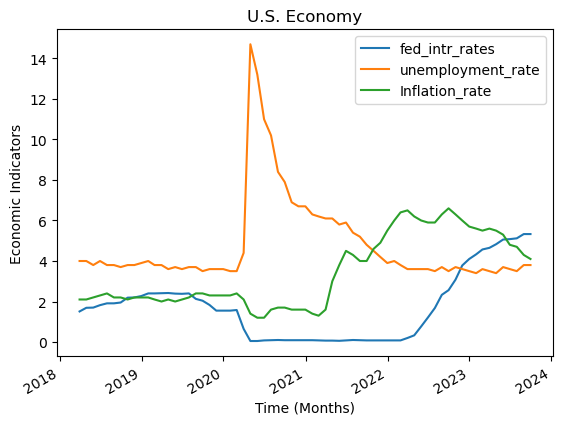

In [15]:
# Creating a duplicate of the preprocessed input dataset
copy_df = dataset.copy()
copy_df.sort_values('Month', inplace=True)

copy_df.set_index('Month', inplace=True)  # Set the 'date' column as the index

# Plot the 4 columns
copy_df[['fed_intr_rates', 'unemployment_rate', 'Inflation_rate']].plot()

plt.xlabel('Time (Months)')
plt.ylabel('Economic Indicators')
plt.title('U.S. Economy')
plt.grid(False)
plt.show()
del copy_df


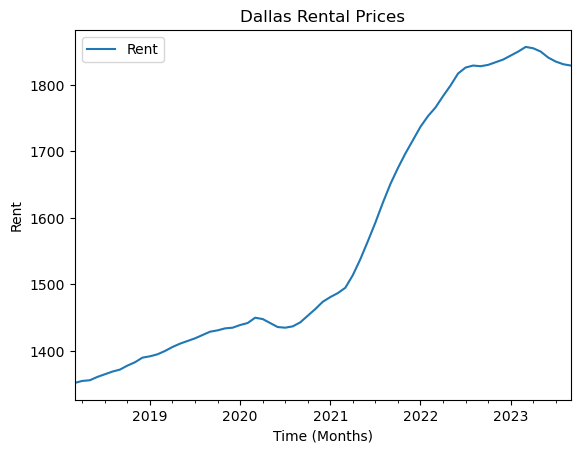

In [16]:
tmp_df = dataset[dataset['RegionName'] == 'Dallas, TX']
tmp_df.set_index('Month', inplace=True)  # Set the 'date' column as the index

# Plot the 4 columns
tmp_df[['Rent']].plot()

plt.xlabel('Time (Months)')
plt.ylabel('Rent')
plt.title('Dallas Rental Prices')
plt.show()
del tmp_df


In [17]:
categorical = [var for var in dataset.columns if dataset[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)


There are 2 categorical variables

The categorical variables are :

 ['RegionName', 'StateName']


In [18]:
numerical = [var_1 for var_1 in dataset.columns if dataset[var_1].dtype in ['int64','float64']]

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :\n\n', numerical)


There are 6 numerical variables

The numerical variables are :

 ['Rent', 'no_of_listings', 'avg_home_value', 'Inflation_rate', 'fed_intr_rates', 'unemployment_rate']


In [19]:
# Using LabelEncoder to numerically encode categorical columns in the dataset.
from sklearn.preprocessing import LabelEncoder

# List of columns to encode
columns_to_encode = ['RegionName', 'StateName','Month']

# Dictionary to hold LabelEncoder objects for each column
encoders = {}

# Encode each column with a separate LabelEncoder
for column in columns_to_encode:
    le = LabelEncoder()
    dataset[column] = le.fit_transform(dataset[column])
    encoders[column] = le


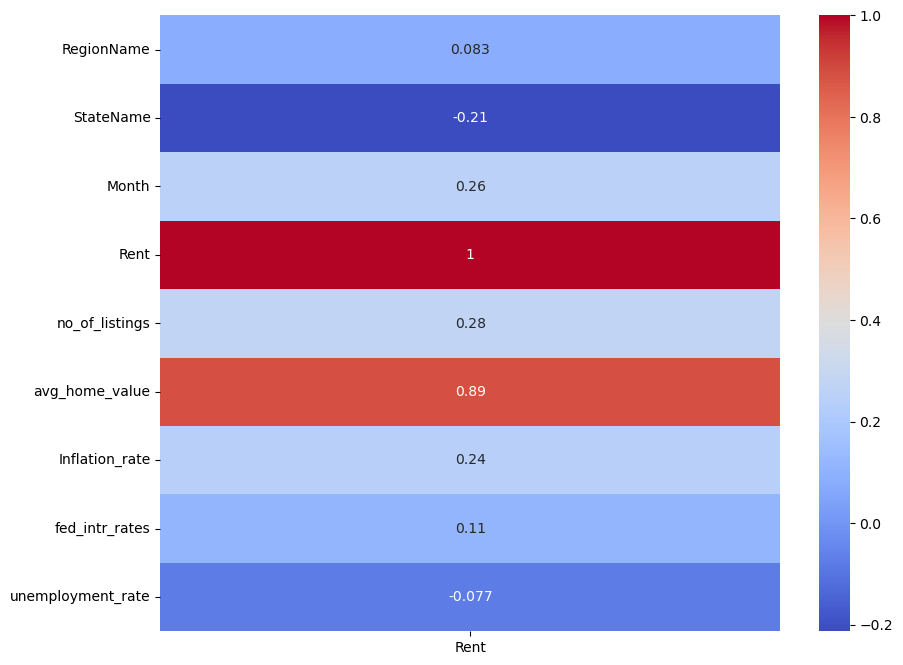

In [20]:
correlation = dataset.corr()
correlation_rent = correlation['Rent']

# Plotting
plt.figure(figsize=(10,8))
sns.heatmap(correlation_rent.to_frame(), annot=True, cmap='coolwarm')
plt.show()


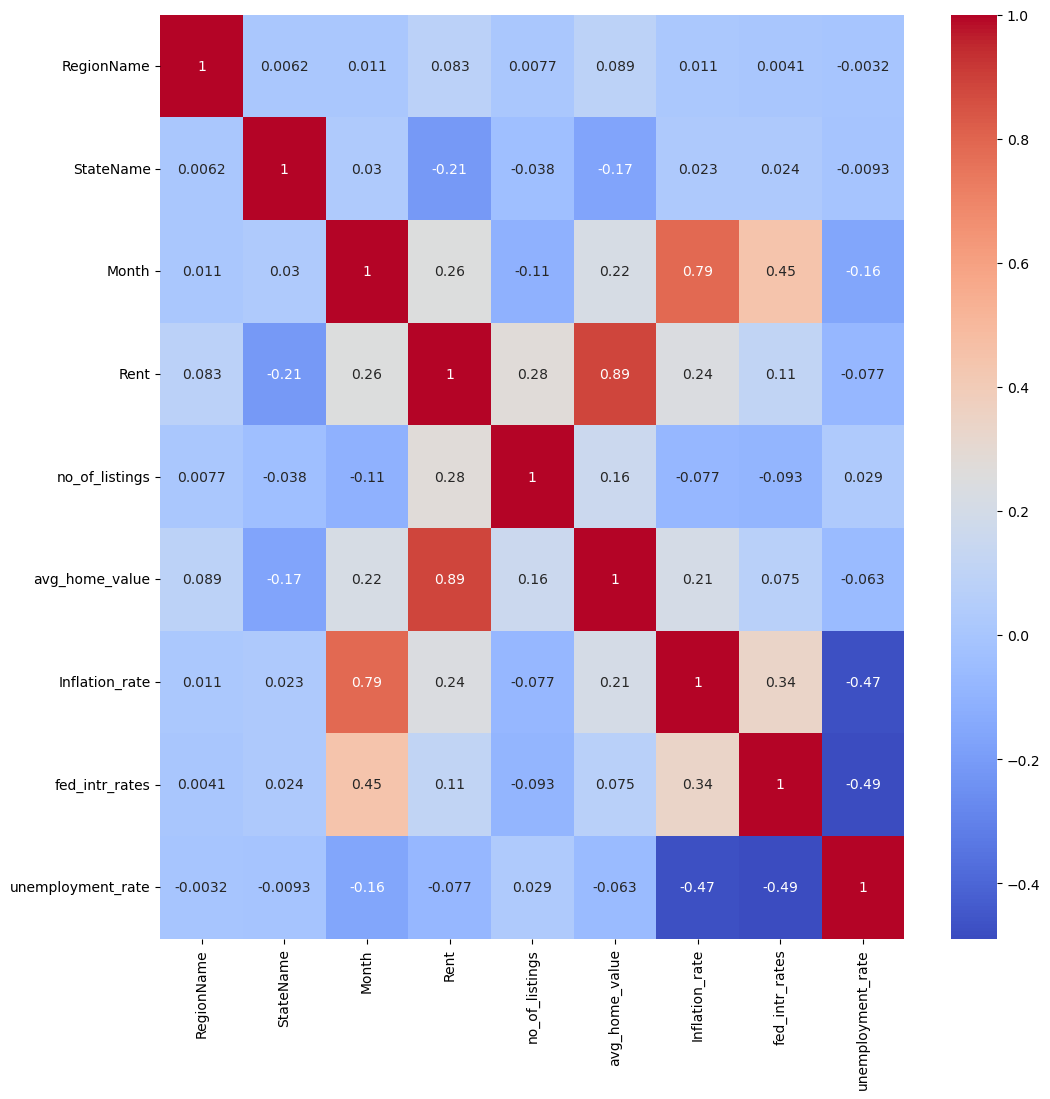

In [21]:
correlation_matrix = dataset.corr()

# Heatmap of correlation matrix
plt.figure(figsize=(12,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [22]:
X, y = dataset.drop('Rent', axis=1), dataset[['Rent']]


In [23]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42,shuffle=True)


In [24]:
# Hyperparameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def tune_hyperparameters(X_train, y_train, X_test, y_test):
    # Define the objective function        
    def objective(space):
        clf = xgb.XGBRegressor(n_estimators = space['n_estimators'],    
                               max_depth = int(space['max_depth']),
                               learning_rate = space['learning_rate'],
                               gamma = space['gamma'],
                               min_child_weight = space['min_child_weight'],
                               subsample = space['subsample'],
                               colsample_bytree = space['colsample_bytree'])
        # To fix warnings
        clf.set_params(early_stopping_rounds=10,eval_metric="rmse")

        eval_set = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

        pred = clf.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        return {'loss':rmse, 'status': STATUS_OK }
    
    # Define the search space
    space ={
            'max_depth': hp.quniform("x_max_depth", 5, 15, 1),
            'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
            'subsample': hp.uniform ('x_subsample', 0.7, 1),
            'n_estimators' : hp.choice('n_estimators', range(50, 1000)),
            'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
            'gamma' : hp.quniform('gamma', 0.1, 0.5, 0.01),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.1 , 1.0 , 0.01)}
    
    trials = Trials()

    # Run the algorithm        
    best_hyperparams = fmin(fn = objective,
                    space = space,
                    algo = tpe.suggest,
                    max_evals = 100,
                    trials = trials)
        
    print(best_hyperparams)
    
    return best_hyperparams
        

In [25]:
import os
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)
        
def json_numpy_deserializer(data):
    for key, value in data.items():
        if isinstance(value, list):
            data[key] = np.array(value)
        elif isinstance(value, int):
            data[key] = np.int64(value)
        elif isinstance(value, float):
            data[key] = np.float64(value)
    return data


def get_best_hyperparameters(X_train, y_train, X_test, y_test):
    if not os.path.isfile('./xgb_best_hyperparams.json'):
        best_hyperparams = tune_hyperparameters(X_train, y_train, X_test, y_test)
        with open('./xgb_best_hyperparams.json', 'w') as f:
            json.dump(best_hyperparams, f, cls=NpEncoder)
    else:
        with open('./xgb_best_hyperparams.json', 'r') as f:
            best_hyperparams = json.load(f, object_hook=json_numpy_deserializer)
            
    return best_hyperparams


In [26]:
# Set Hyperparameter
xgb_best_hyperparams = get_best_hyperparameters(X_train, y_train, X_test, y_test)


In [38]:
# Fitting the model
xgb_model = xgb.XGBRegressor(**xgb_best_hyperparams,verbosity=0)
xgb_model.fit(X_train, y_train)

# xgb_params = xgb_model.get_params()


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.91, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=496, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

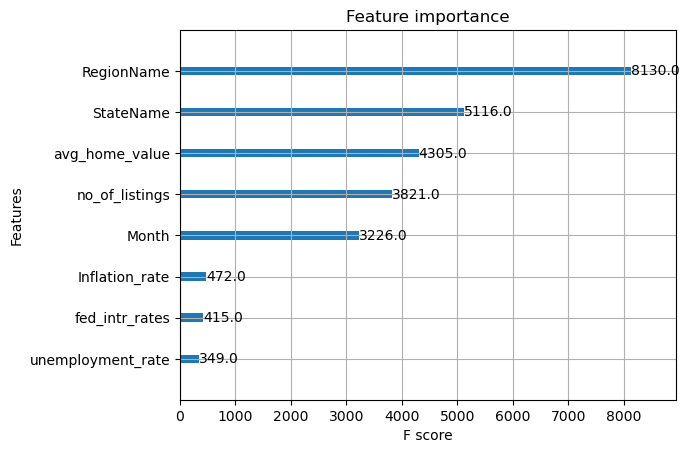

In [39]:
xgb.plot_importance(xgb_model)
plt.show()

In [40]:
y_pred = xgb_model.predict(X_train)


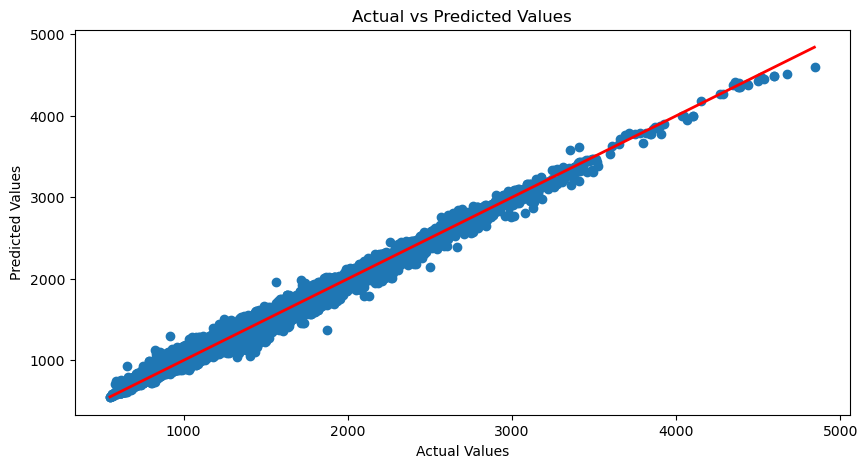

In [41]:
plt.figure(figsize=(10, 5))
plt.scatter(y_train, y_pred)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Plotting the identity line
line_coords = range(np.min(y_train), np.max(y_train))
plt.plot(line_coords, line_coords, 'r', linewidth=2)  # The identity line

plt.show()


In [42]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("R2 score : %.2f" % r2_score(y_train,y_pred))
print('MSE: %.2f' % mean_squared_error(y_train,y_pred))
print('MAE: %.2f' % mean_absolute_error(y_train,y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_train,y_pred))

R2 score : 0.99
MSE: 3022.11
MAE: 39.36
MAPE:  0.030850266481685092


(15607,)


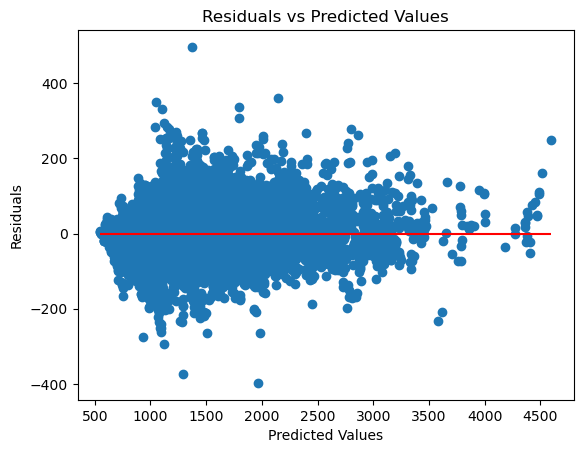

In [43]:
# Scatter plot of predicted values vs residuals

# The residuals
y_vals = y_train.values
y_vals = y_vals.reshape(-1)
residuals = y_vals - y_pred
print(residuals.shape)

plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.hlines(y = 0, xmin = np.min(y_pred), xmax = np.max(y_pred), color = 'red')
plt.show()

In [44]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores
print("Mean MSE:", np.mean(mse_scores))
print("Standard deviation of MSE:", np.std(mse_scores))


Mean MSE: 8929.710404315974
Standard deviation of MSE: 5929.065940441906


In [45]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()


# Define the grid of hyperparameters to search
param_grid = {
    'fit_intercept': [True, False],
}

# Use GridSearchCV to fine-tune the model
linear_model = GridSearchCV(linear_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the search
results = linear_model.fit(X_train, y_train)

#linear_params = linear_model.get_params()

# Summarize
print(f"Best parameters: {results.best_params_}")
print(f"Best MSE score: {results.best_score_}")


Best parameters: {'fit_intercept': True}
Best MSE score: -45812.115572147275


In [53]:
# Predicting the Test set results
y_pred = linear_model.predict(X_train)


In [54]:
print("R2 score : %.2f" % r2_score(y_train,y_pred))
print('MSE: %.2f' % mean_squared_error(y_train,y_pred))
print('MAE: %.2f' % mean_absolute_error(y_train,y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_train,y_pred))


R2 score : 0.82
MSE: 45683.31
MAE: 155.53
MAPE:  0.12175634395055787


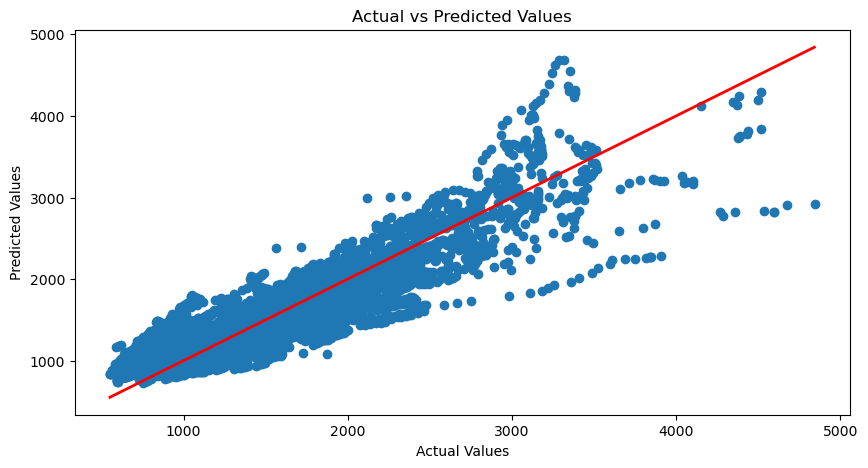

In [55]:
plt.figure(figsize=(10, 5))
plt.scatter(y_train, y_pred)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Plotting the identity line
line_coords = range(np.min(y_train), np.max(y_train))
plt.plot(line_coords, line_coords, 'r', linewidth=2)  # The identity line

plt.show()

(15607, 1)


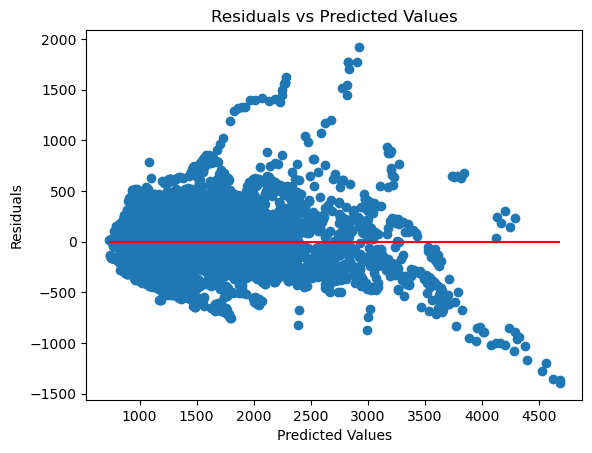

In [56]:
# Scatter plot of predicted values vs residuals
residuals = y_train - y_pred
print(residuals.shape)

plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.hlines(y = 0, xmin = np.min(y_pred), xmax = np.max(y_pred), color = 'red')
plt.show()

In [57]:
# Fitting the model to the entire dataset
xgb_model.fit(X,y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.91, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=496, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [58]:
# Fitting the model to the entire dataset
linear_results = linear_model.fit(X,y)


In [59]:
# TODO: Model summary for linear regression and xgboost

In [60]:
# TODO: Add Random Forest and other models

In [61]:
pd.set_option('mode.chained_assignment', None)

def predict_rentals(base_ds,xgb_model,file_name,months=1,listings=0,hvalue=0,inf_rate=0,fed_rate=0,unem_rate=0):

    base_ds['predict'] = 'N' # flagging existing rows
    max_ds=base_ds[base_ds['Month']==base_ds['Month'].max()] # picking recent row from all regions
    
    for i in range(1,months+1):
        # Generating dataset from latest month values
        temp_ds = max_ds.copy()
        temp_ds['Month']= max_ds['Month'].max() + pd.DateOffset(months=i)
        temp_ds["avg_home_value"]= max_ds["avg_home_value"]+((max_ds["avg_home_value"]*hvalue)/100)
        temp_ds["no_of_listings"]= max_ds["no_of_listings"]+((max_ds["no_of_listings"]*listings)/100)        
        temp_ds["Inflation_rate"]= max_ds["Inflation_rate"]+((max_ds["Inflation_rate"]*inf_rate)/100)
        temp_ds["fed_intr_rates"]= max_ds["fed_intr_rates"]+fed_rate
        temp_ds["unemployment_rate"]= max_ds["unemployment_rate"]+((max_ds["unemployment_rate"]*unem_rate)/100)
        temp_ds["predict"]='Y'
                
        # Encode complete dataset
        X_inc = pd.concat([base_ds, temp_ds])
        
        # List of columns to encode
        columns_to_encode = ['RegionName', 'StateName','Month']

        # Dictionary to hold LabelEncoder objects for each column
        inc_encoders = {}

        # Encode each column with a separate LabelEncoder
        for column in columns_to_encode:
            le = LabelEncoder()
            X_inc[column] = le.fit_transform(X_inc[column])
            inc_encoders[column] = le
        
        ds_enc = X_inc[X_inc["predict"]=='Y']
        X_pred = ds_enc.drop(['Rent','predict'], axis=1)

        y_pred = xgb_model.predict(X_pred)
        temp_ds['Rent'] = y_pred
        temp_ds['predict']='N'
                
        # Append to the base dataset
        base_ds = pd.concat([base_ds, temp_ds])
        
        # Retrain the model with updated data
        full_ds = base_ds.drop(['predict'], axis=1)
        
        # Dictionary to hold LabelEncoder objects for each column
        encoders = {}

        # Encode each column with a separate LabelEncoder
        for column in columns_to_encode:
            le = LabelEncoder()
            full_ds[column] = le.fit_transform(full_ds[column])
            encoders[column] = le
            
        X_full, y_full = full_ds.drop('Rent', axis=1), full_ds[['Rent']]
        
        # Fitting the model to the entire dataset
        xgb_model.fit(X_full,y_full)
        del full_ds
        
    # saving predicted values
    out_file = './datasets/' + file_name
    base_ds.to_csv(out_file)
    

In [62]:
predict_rentals(final_ds,xgb_model,'rent_prediction_xgb.csv',months=12)


In [63]:
predict_rentals(final_ds,linear_model,'rent_prediction_linear.csv',months=12)


In [64]:
# Plotting the data
def plot_results(ds, title):
    # Creating a duplicate of the preprocessed input dataset
    tmp_df = ds[ds['RegionName'] == 'Dallas, TX']
    tmp_df.sort_values('Month', inplace=True)

    # create figure and plot space
    fig, ax = plt.subplots(figsize=(12, 12))

    # plotting multiple Y columns with different colors
    ax.plot(tmp_df['Month'],tmp_df['Rent'],color='red',label='Rent')

    # set title and labels for axes
    # setting labels and title
    ax.set_xlabel('Time (Months)')
    ax.set_ylabel('Rent')
    ax.set_title(title)

    # Adding legend
    ax.legend()

    # define the date format
    date_form = mdates.DateFormatter("%Y-%m")
    ax.xaxis.set_major_formatter(date_form)

    # ensure a major tick for each year
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # to ensure subplots do not overlap
    plt.tight_layout()  
    plt.show()

    del tmp_df


In [65]:
result_ds = pd.read_csv('./datasets/rent_prediction_xgb.csv')
result_ds["Month"] = pd.to_datetime(result_ds['Month'], format='%Y-%m-%d')


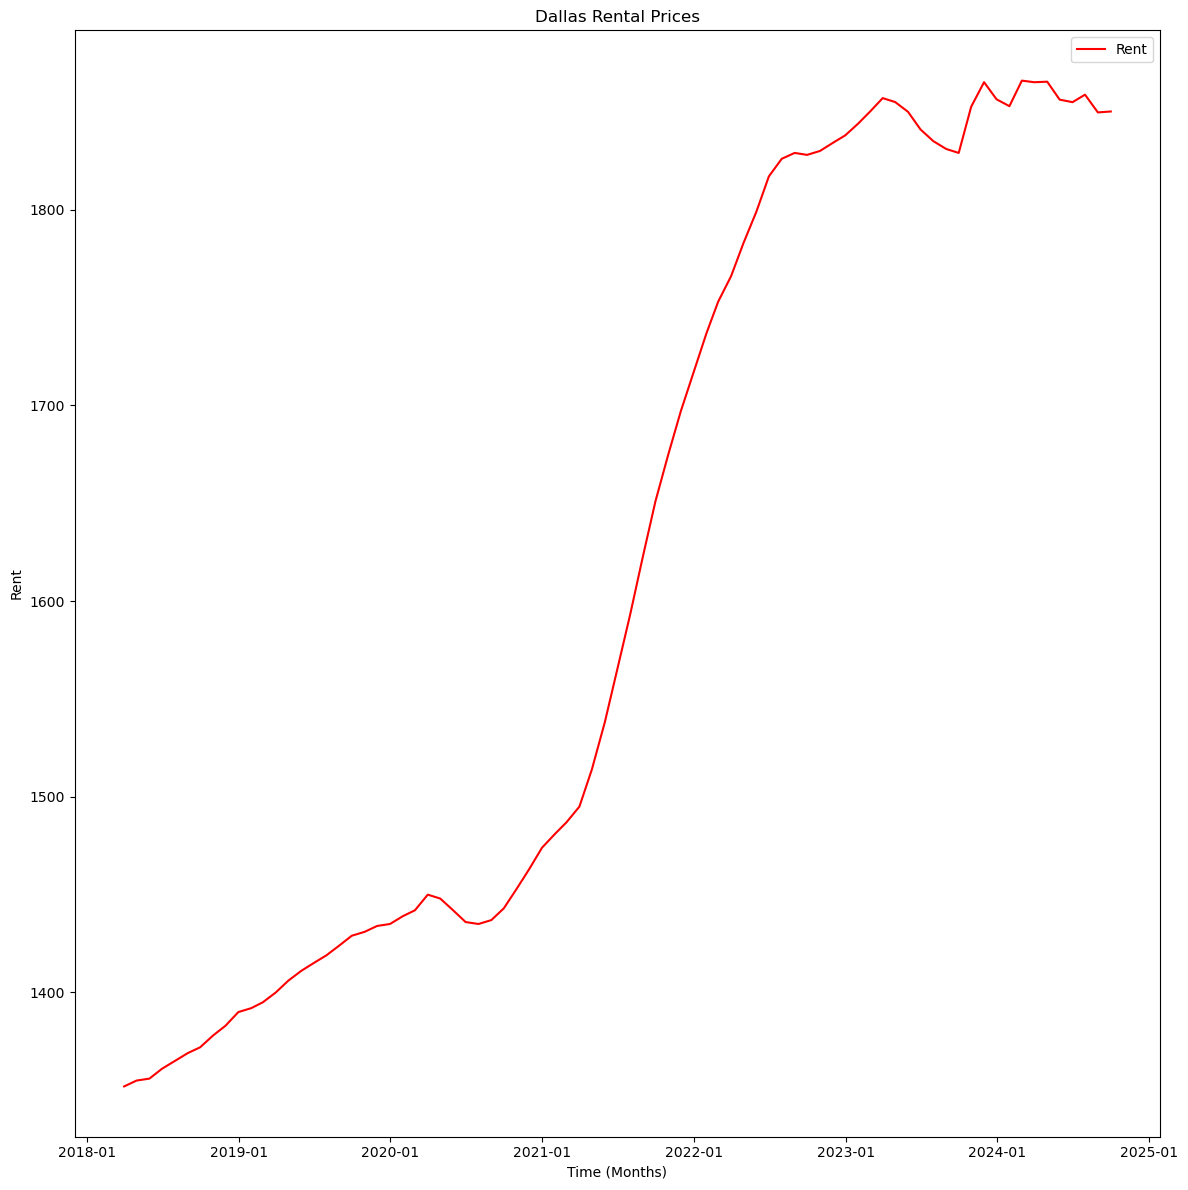

In [66]:
plot_results(result_ds, 'Dallas Rental Prices')


In [67]:
result_ds = pd.read_csv('./datasets/rent_prediction_linear.csv')
result_ds["Month"] = pd.to_datetime(result_ds['Month'], format='%Y-%m-%d')



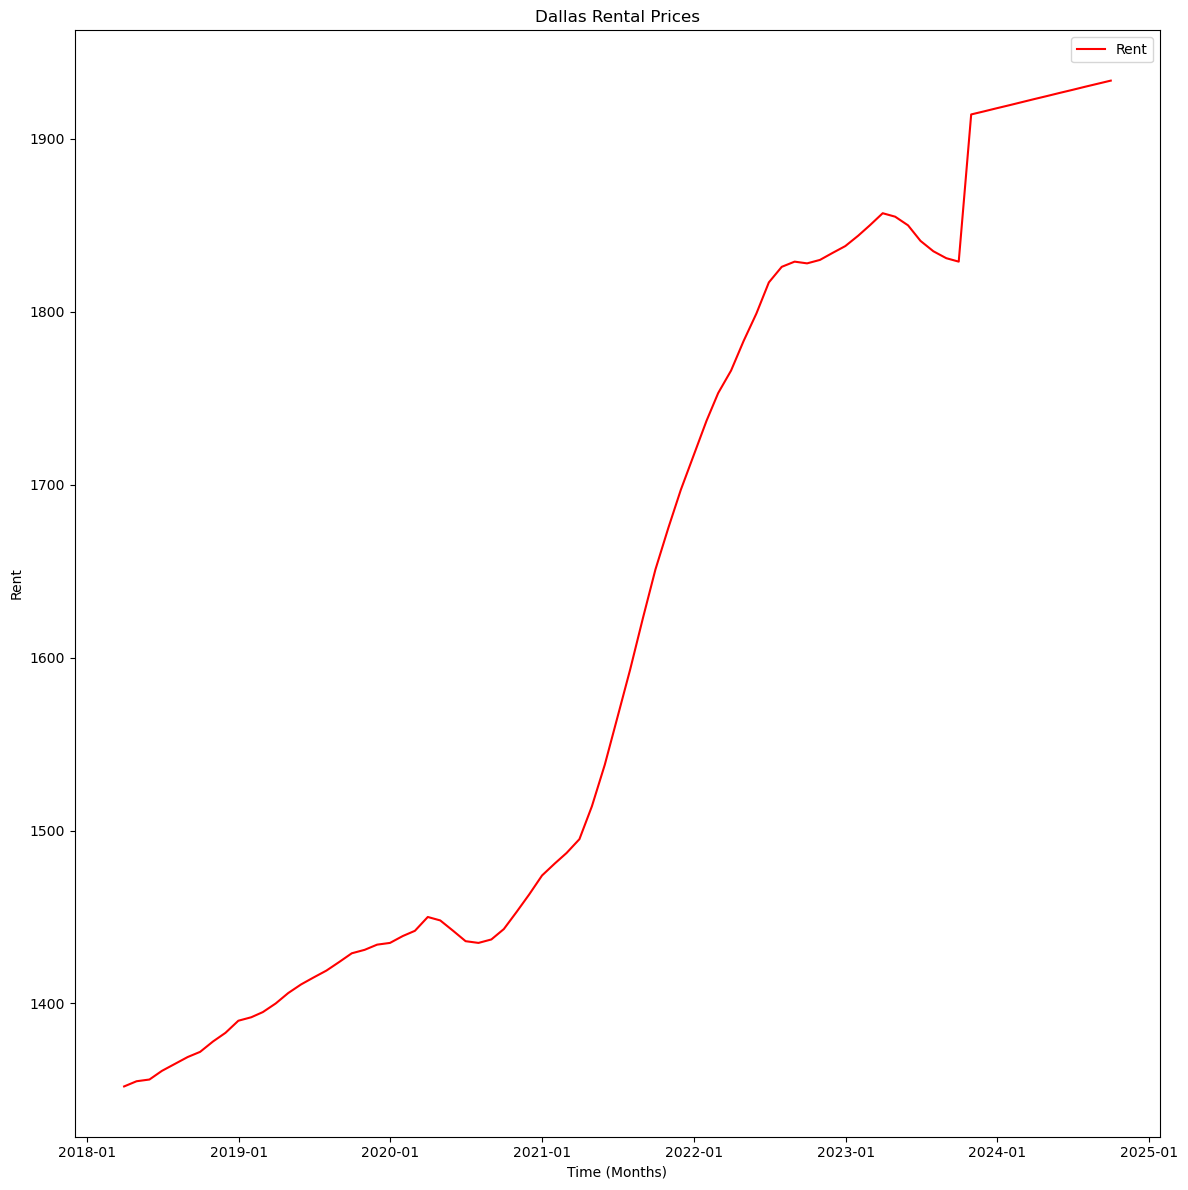

In [68]:
plot_results(result_ds, 'Dallas Rental Prices')


In [ ]:
# Neutral -- no changes to features
predict_rentals(final_ds,xgb_model,'rent_prediction_no_changes.csv',months=12)
no_changes_ds = pd.read_csv('./datasets/rent_prediction_no_changes.csv')
no_changes_ds["Month"] = pd.to_datetime(no_changes_ds['Month'], format='%Y-%m-%d')


# rent increase scenario -- 
predict_rentals(final_ds,xgb_model,'rent_prediction_rent_incr.csv',months=12,listings=5,hvalue=10,inf_rate=10,fed_rate=-0.25,unem_rate=-10)
rent_incr = pd.read_csv('./datasets/rent_prediction_rent_incr.csv')
rent_incr["Month"] = pd.to_datetime(rent_incr['Month'], format='%Y-%m-%d')


# rent decrease scenario -- 
predict_rentals(final_ds,xgb_model,'rent_prediction_rent_decr.csv',months=12,listings=-5,hvalue=-10,inf_rate=-10,fed_rate=0-0.25,unem_rate=10)
rent_decr = pd.read_csv('./datasets/rent_prediction_rent_decr.csv')
rent_decr["Month"] = pd.to_datetime(rent_decr['Month'], format='%Y-%m-%d')

final_1=pd.merge(no_changes_ds,rent_incr,how='inner',on=['RegionName','Month'],suffixes=("", "_y"),)
final_2=final_1.loc[:, ['RegionName','StateName','Month','Rent','no_of_listings','avg_home_value','Inflation_rate','fed_intr_rates','unemployment_rate','Rent_y']]
final_3=final_2.rename(columns={"Rent_y": "Rent_pos"})
final_4=pd.merge(final_3,rent_decr,how='inner',on=['RegionName','Month'],suffixes=("", "_y"),)
final_5=final_4.loc[:, ['RegionName','StateName','Month','Rent','no_of_listings','avg_home_value','Inflation_rate','fed_intr_rates','unemployment_rate','Rent_pos','Rent_y']]
combined_ds=final_5.rename(columns={"Rent_y": "Rent_neg"})
del final_1
del final_2
del final_3
del final_4
del final_5


combined_ds.to_csv('./datasets/combined_final.csv')

In [ ]:

# rent increase scenario -- 
predict_rentals(final_ds,xgb_model,'rent_prediction_rent_demo.csv',months=6,listings=5,hvalue=5,inf_rate=20,fed_rate=-0.50,unem_rate=-20)
rent_demo = pd.read_csv('./datasets/rent_prediction_rent_demo.csv')
rent_demo["Month"] = pd.to_datetime(rent_demo['Month'], format='%Y-%m-%d')


rent_demo[(rent_demo['RegionName'] == 'Dallas, TX') & (rent_demo['Month'] > '2023-01-31')]

